In [3]:
# Import my packages.
import flymovie as fm
import tensorflow as tf
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import dask
from time import sleep
import seaborn as sns
import itertools

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [4]:
def prepare_hist_param_data(data, num_hist_bins=400, param_pos=0, data_pos=1):
    """Process data output from blob simulator (list of tuples, 
    0 is params, 1 is 2d histogram) for feeding to ML function. 
    
    For histograms: 
        - Bin (if desired)
        - Normalize each 1d histogram by dividing by sum (-> probabilities)
        - Flatten
        - Take log (after adding a bit to avoid 0)

    For parameters:
        - Combine into single 2d numpy array (rows are entries)
        - Normalize each column (mean 0 sd 1)
    
         """
    def check2d(a):
        """Add dummy first dimension if array is 1d."""
        if len(a.shape) < 2:
            a = np.expand_dims(a, axis=0)
        return a

    def rebin(a, shape):
        sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
        return a.reshape(sh).mean(-1).mean(1)

    def norm_columns(x):
        """Normalize columns to mean=0 SD=1."""
        x1 = x.copy()
        for i in range(0, x.shape[1]):
            sd = np.std(x[:,i])
            if sd > 0:
                x1[:,i] = (x[:,i] - np.mean(x[:,i])) / sd
            else:
                x1[:,i] = np.zeros(len(x1[:,i]))
        return x1

    num_sigmas = check2d(data[0][data_pos]).shape[0]
    num_params = len(data[0][param_pos])
    num_entries = len(data)
    histograms_processed = np.zeros((num_entries, num_sigmas * num_hist_bins))
    params = np.zeros((num_entries, num_params))

    for i in range(num_entries):
        params[i] = data[i][param_pos]
        hist2d = data[i][data_pos].copy()
        hist2d = check2d(hist2d)
        # Bin histograms.
        hist2d = rebin(hist2d, [hist2d.shape[0], num_hist_bins])
        # Normalize by dividing by row sum.
        hist2d = np.apply_along_axis(lambda x: x / np.sum(x), axis=1, arr=hist2d)
        # Flatten.
        hist_flattened = hist2d.flatten()
        # Add small number to account for 0s, take log, assign.
        zero_pad = np.min(hist_flattened[hist_flattened > 0]) / 100
        hist_flatlog = np.log(hist_flattened + zero_pad)
        histograms_processed[i] = hist_flatlog

    params = norm_columns(params)    
    return histograms_processed, params

def create_training_test_data(data, num_hist_bins=100, n_leaveout=100, param_pos=0, data_pos=1, permute=True):
    histograms, params = prepare_hist_param_data(data, num_hist_bins, param_pos, data_pos)
    if permute:
        p = np.random.permutation(histograms.shape[0])
    else:
        p = np.arange(0, histograms.shape[0])

    if n_leaveout > 0:       
        x_train = histograms[p[:-n_leaveout]]
        y_train = params[p[:-n_leaveout]]
        x_test = histograms[p[-n_leaveout:]]
        y_test = params[p[-n_leaveout:]]
        
        return x_train, y_train, x_test, y_test
    else:
        x_train, y_train = histograms, params
        return x_train, y_train

def difference_hist_params(histograms, params, dist_func=scipy.spatial.distance.euclidean):
    num_entries = histograms.shape[0]
    hist_diffs = np.zeros((num_entries * num_entries, histograms.shape[1]))
    param_diffs = np.zeros(num_entries * num_entries)
    for i in range(num_entries):
        start = i * num_entries
        hist_diffs[start : (start + num_entries)] = histograms - histograms[i]
        # Get parameter distances.
        param_diffs[start : (start + num_entries)] = np.apply_along_axis(lambda x: dist_func(x, params[i]), axis=1, arr=params)

    return hist_diffs, param_diffs

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def merge_data(x_train1, x_train2, y_train1, y_train2):
    def argsortcols(a, cols):
        cols_ext = []
        for col in cols:
            cols_ext.append(a[:,col])
        return np.lexsort(cols_ext)

    order1 = argsortcols(y_train1, np.arange(0, y_train1.shape[1]))
    order2 = argsortcols(y_train2, np.arange(0, y_train2.shape[1]))
    y_train1_new = y_train1[order1]
    y_train2_new = y_train2[order2]
    if np.max(abs(y_train1_new - y_train2_new)) > 1e-5:
        raise ValueError('Sorted y_train sets are not identical')
    x_train_new = np.hstack((x_train1[order1], x_train2[order2]))
    return x_train_new, y_train1_new

def make_data_similarity(x_in, y_in, num_sample, num_diff):
    total = num_sample * num_diff
    x = np.zeros((total, x_in.shape[1]))
    y = np.zeros((total, 1))
    indexes = np.arange(0, x_in.shape[0])
    sampled_indexes1 = np.random.choice(indexes, size=num_sample, replace=False)
    for i in range(len(sampled_indexes1)):
        start = i * num_diff
        end = start + num_diff
        index1 = sampled_indexes1[i]
        indexes_sansself = np.concatenate((indexes[:index1], indexes[(index1 + 1):]))
        sampled_indexes2 = np.random.choice(indexes_sansself, size=num_diff, replace=False)
        x_sub = x_in[sampled_indexes2]
        y_sub = y_in[sampled_indexes2]
        x_diffs = x_sub - x_in[index1]
        y_diffs = np.sum((y_sub - y_in[index1]) ** 2, axis=1) # sum of squared differences
        x[start:end] = x_diffs
        y[start:end] = np.expand_dims(y_diffs, axis=1)

    return x, y

In [8]:
data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-doghist_0p5_4_by0p5-200bins-2.pkl')
x_train, y_train, x_test1, y_test1 = create_training_test_data(data, 200, param_pos=0, data_pos=1)

In [29]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-6
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(1400, 7)
history = model.fit(x_train[:1000], y_train[:1000], validation_split=0.1,epochs=2, verbose=True)

Train on 900 samples, validate on 100 samples
Epoch 1/2
900/900 [==============================] - 2s 2ms/sample - loss: 40.7209 - val_loss: 5.3832
Epoch 2/2
900/900 [==============================] - 0s 443us/sample - loss: 2.9145 - val_loss: 3.6298


## Bug time

Hit a massive problem that stopped me for days where the models I trained on savio could not be loaded on this mac. I think/hope I have solved this by harmonizing the tensorflow versions. It seems that using tensorflow 2.4.1 on both machines (through conda env tf2 on this machine) allows them to be loaded. I have no fucking idea why this is a thing, but it is. Want to do murder.

So where am I now? Let's take stock.

- Re-did simulations using sampled parameters. Easier because we can just arbitrarily dial more up by changing one parameter.
- Currently using scalespace and "dog-space" representations. It's pretty undercooked what is useful here...
- Worked out doing this on Savio, trained models for predicting parameters and differences with large training sets.
- Working on miserable tensorflow version issues, need to test performance.

In [7]:
diff_model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/sims-sampling-sshist-doghist-250k-predictdiffs-model/model')

In [8]:
param_model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/sims-sampling-sshist-doghist-250k-predictparams-model/model')

In [65]:
x_params, y_params = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-sampling-sshist-doghist-10k_yDBH8cevTa_hist_training.pkl')

In [66]:
pred = param_model.predict(x_params)

Text(0.5, 1.0, 'Learned parameters')

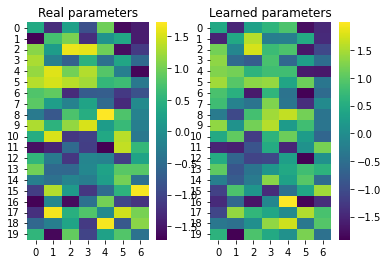

In [67]:
fig, ax = plt.subplots(1,2)
axes = np.ravel(ax)
#axes[0].imshow(y_params[:20])
sns.heatmap(y_params[:20], ax=axes[0], cmap='viridis')
axes[0].set_title('Real parameters')
sns.heatmap(pred[:20], ax=axes[1], cmap='viridis')
axes[1].set_title('Learned parameters')

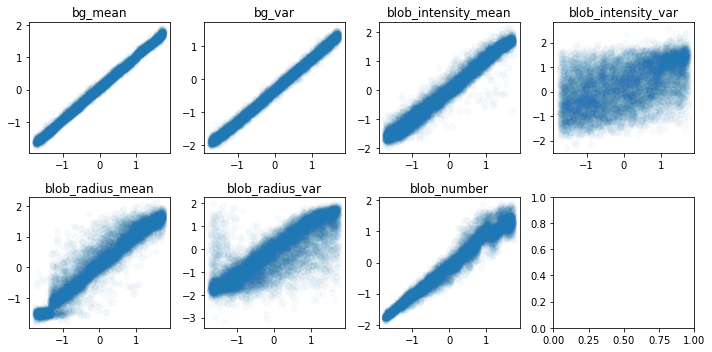

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(10,5))
params = ['bg_mean', 'bg_var', 'blob_intensity_mean', 'blob_intensity_var', 'blob_radius_mean', 
            'blob_radius_var', 'blob_number']
ax = np.ravel(axes)
for col in range(7):
    ax[col].scatter(y_params[:,col], pred[:,col], alpha=0.025)
    ax[col].set_title(params[col])
plt.tight_layout()

### Conclusions:

The predictions are very good. The only parameters that are not well-predicted are the two variance parameters, which isn't surprising. Most critically, blob number and intensity are super well predicted.

## Moving on to differences

In [56]:
x_diffs, y_diffs = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-sampling-sshist-doghist-10k_yDBH8cevTa_diff_training.pkl')

In [59]:
diffpred = diff_model.predict(x_diffs)

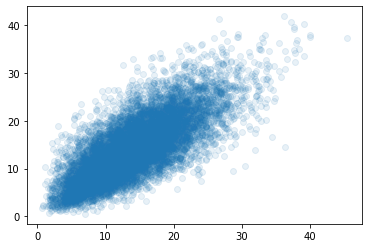

In [61]:
plt.scatter(diffpred, y_diffs, alpha=0.1)

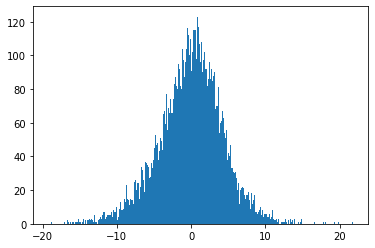

In [63]:
plt.hist(diffpred - y_diffs, bins=400);

#### Hmm, this is much less good. I think I need to back out a big and play with the design more.

Let's try a few things. I did some small simulations (300 sims) wiht different histogram parameters. Let's see if this makes a difference.

In [76]:
def do_model(x_train, y_train, epochs=10):
    
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
        )

    def get_model(n_inputs, n_outputs):
        reg=1e-6
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(n_outputs))
        model.compile(loss='mse', optimizer=optimizer)
        return model

    n_inputs = x_train.shape[1]
    model = get_model(n_inputs, 1)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, callbacks=[callback], verbose=True)
    return model, history


In [8]:
n = 20_000

In [34]:
# Fewest sigmas.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_pTskpe6fix_diff_training.pkl')
out1 = do_model(x_train, y_train, 30)

Epoch 1/30
2498/2498 [==============================] - 15s 6ms/step - loss: 19.8023 - val_loss: 16.1585
Epoch 2/30
2498/2498 [==============================] - 16s 6ms/step - loss: 7.9247 - val_loss: 12.9031
Epoch 3/30
2498/2498 [==============================] - 16s 7ms/step - loss: 3.1908 - val_loss: 12.9809
Epoch 4/30
2498/2498 [==============================] - 17s 7ms/step - loss: 2.0222 - val_loss: 12.2273
Epoch 5/30
2498/2498 [==============================] - 17s 7ms/step - loss: 1.5961 - val_loss: 12.1334
Epoch 6/30
2498/2498 [==============================] - 17s 7ms/step - loss: 1.2731 - val_loss: 11.9296
Epoch 7/30
2498/2498 [==============================] - 16s 7ms/step - loss: 1.0809 - val_loss: 11.3053
Epoch 8/30
2498/2498 [==============================] - 16s 7ms/step - loss: 0.9481 - val_loss: 11.3941
Epoch 9/30
2498/2498 [==============================] - 16s 7ms/step - loss: 0.8486 - val_loss: 10.9511
Epoch 10/30
2498/2498 [==============================] - 16s 7m

In [23]:
# Medium sigmas.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_ILkGcBZE4e_diff_training.pkl')
out2 = do_model(x_train, y_train, 30)

Epoch 1/30
2498/2498 [==============================] - 17s 7ms/step - loss: 20.3926 - val_loss: 18.6924
Epoch 2/30
2498/2498 [==============================] - 17s 7ms/step - loss: 8.0646 - val_loss: 14.7364
Epoch 3/30
2498/2498 [==============================] - 17s 7ms/step - loss: 3.4531 - val_loss: 13.6998
Epoch 4/30
2498/2498 [==============================] - 17s 7ms/step - loss: 2.1523 - val_loss: 11.9687
Epoch 5/30
2498/2498 [==============================] - 18s 7ms/step - loss: 1.6250 - val_loss: 12.2571
Epoch 6/30
2498/2498 [==============================] - 17s 7ms/step - loss: 1.3588 - val_loss: 10.7461
Epoch 7/30
2498/2498 [==============================] - 17s 7ms/step - loss: 1.1286 - val_loss: 11.5730
Epoch 8/30
2498/2498 [==============================] - 17s 7ms/step - loss: 1.0435 - val_loss: 10.4312
Epoch 9/30
2498/2498 [==============================] - 18s 7ms/step - loss: 0.8940 - val_loss: 10.9619
Epoch 10/30
2498/2498 [==============================] - 18s 7m

In [22]:
# Most sigmas.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_rtuTv6USa3_diff_training.pkl')
out3 = do_model(x_train, y_train, 30)

Epoch 1/30
2498/2498 [==============================] - 22s 9ms/step - loss: 20.0532 - val_loss: 12.8963
Epoch 2/30
2498/2498 [==============================] - 22s 9ms/step - loss: 7.9719 - val_loss: 11.4320
Epoch 3/30
2498/2498 [==============================] - 22s 9ms/step - loss: 5.4149 - val_loss: 9.0286
Epoch 4/30
2498/2498 [==============================] - 23s 9ms/step - loss: 2.1162 - val_loss: 7.6962
Epoch 5/30
2498/2498 [==============================] - 23s 9ms/step - loss: 1.6748 - val_loss: 7.0581
Epoch 6/30
2498/2498 [==============================] - 22s 9ms/step - loss: 1.2957 - val_loss: 7.3650
Epoch 7/30
2498/2498 [==============================] - 22s 9ms/step - loss: 1.1184 - val_loss: 6.6785
Epoch 8/30
2498/2498 [==============================] - 22s 9ms/step - loss: 1.0823 - val_loss: 5.9126
Epoch 9/30
2498/2498 [==============================] - 20s 8ms/step - loss: 0.8645 - val_loss: 5.6748
Epoch 10/30
2498/2498 [==============================] - 21s 8ms/step 

In [32]:
def plot_loss(x, col):
    plt.plot(x[1].history['loss'], color=col)
    plt.plot(x[1].history['val_loss'], color=col)

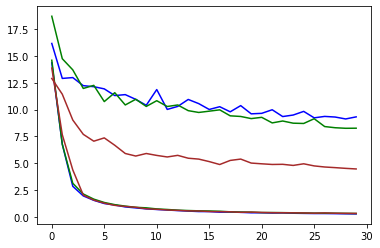

In [35]:
plot_loss(out1, 'blue')
plot_loss(out2, 'green')
plot_loss(out3, 'brown')

In [7]:
# More sigmas.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_moresigmas_JPd2WFxwjE_diff_training.pkl')
out3 = do_model(x_train, y_train, 30)

2021-11-29 18:18:00.492979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 18:18:02.191748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/30
2498/2498 [==============================] - 34s 13ms/step - loss: 18.5152 - val_loss: 13.6256
Epoch 2/30
2498/2498 [==============================] - 36s 15ms/step - loss: 8.0922 - val_loss: 11.6687
Epoch 3/30
2498/2498 [==============================] - 37s 15ms/step - loss: 3.9661 - val_loss: 9.6569
Epoch 4/30
2498/2498 [==============================] - 37s 15ms/step - loss: 1.9984 - val_loss: 8.3348
Epoch 5/30
2498/2498 [==============================] - 37s 15ms/step - loss: 1.6405 - val_loss: 7.7897
Epoch 6/30
2498/2498 [==============================] - 37s 15ms/step - loss: 1.3252 - val_loss: 7.4122
Epoch 7/30
2498/2498 [==============================] - 38s 15ms/step - loss: 1.0706 - val_loss: 6.6192
Epoch 8/30
2498/2498 [==============================] - 37s 15ms/step - loss: 0.9464 - val_loss: 6.7069
Epoch 9/30
2498/2498 [==============================] - 38s 15ms/step - loss: 0.8740 - val_loss: 6.0712
Epoch 10/30
2498/2498 [==============================] - 39s 

In [17]:
# More dogs.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_moredogs_CdsQvDc3Ob_diff_training.pkl')
#out4 = do_model(x_train, y_train, 30)

In [38]:
# More both.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_moreboth_hIh9HzNK5b_diff_training.pkl')
out5 = do_model(x_train, y_train, 30)

Epoch 1/30
2498/2498 [==============================] - 40s 16ms/step - loss: 20.1649 - val_loss: 14.3469
Epoch 2/30
2498/2498 [==============================] - 41s 16ms/step - loss: 8.1049 - val_loss: 12.6104
Epoch 3/30
2498/2498 [==============================] - 35s 14ms/step - loss: 3.3510 - val_loss: 9.8818
Epoch 4/30
2498/2498 [==============================] - 35s 14ms/step - loss: 2.1097 - val_loss: 12.4588
Epoch 5/30
2498/2498 [==============================] - 35s 14ms/step - loss: 1.7919 - val_loss: 8.3151
Epoch 6/30
2498/2498 [==============================] - 35s 14ms/step - loss: 1.3593 - val_loss: 7.6419
Epoch 7/30
2498/2498 [==============================] - 35s 14ms/step - loss: 1.1716 - val_loss: 7.1395
Epoch 8/30
2498/2498 [==============================] - 36s 14ms/step - loss: 0.9489 - val_loss: 7.5074
Epoch 9/30
2498/2498 [==============================] - 36s 15ms/step - loss: 0.9033 - val_loss: 6.7124
Epoch 10/30
2498/2498 [==============================] - 35s

In [39]:
x_test, y_test = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/testsims_moreboth_zzkkGCH3y6_diff_training.pkl')

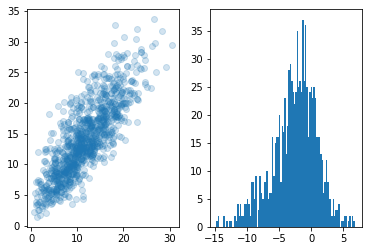

In [44]:
model = out5[0]
n=1_000
plt.subplot(121)
plt.scatter(model.predict(x_test[:n]), y_test[:n], alpha=0.2);
plt.subplot(122)
plt.hist(model.predict(x_test[:n])- y_test[:n], bins=100);

OK it's clear that more parameters in the sim data (sigmas or dogs) is beneficial. That's not super surprising, but informative. It seemed that more sigmas for the scalespace representation made a bigger difference than the DoG features. I'm making another set of 10k sims with a series of sigmas 0.5 to 6 with 0.5 interval. Kind of the full works. We will see.

There are three things here to improve things:
1. Training set size (trivial to increase)
2. Image representation
3. ML hyperparameters

Number 1 kind of comes after the others. So I need to work on the other two. going to focus on 3 first. I'll start with this 10k dataset, and see what I can do on the ML model side.

In [77]:
# Load maxsigma data using simple differences.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_maxsigmas_10k_se82GnD5ep_diff_training.pkl')
out7 = do_model(x_train, y_train, 30)

Epoch 1/30
507/507 [==============================] - 5s 9ms/step - loss: 38.0111 - val_loss: 20.9931
Epoch 2/30
507/507 [==============================] - 4s 9ms/step - loss: 18.6099 - val_loss: 20.4178
Epoch 3/30
507/507 [==============================] - 4s 9ms/step - loss: 15.7152 - val_loss: 18.6784
Epoch 4/30
507/507 [==============================] - 4s 9ms/step - loss: 14.0478 - val_loss: 19.9003
Epoch 5/30
507/507 [==============================] - 5s 9ms/step - loss: 12.8099 - val_loss: 18.5231
Epoch 6/30
507/507 [==============================] - 5s 9ms/step - loss: 11.6645 - val_loss: 18.7810
Epoch 7/30
507/507 [==============================] - 4s 9ms/step - loss: 10.5003 - val_loss: 20.0437
Epoch 8/30
507/507 [==============================] - 4s 9ms/step - loss: 9.4007 - val_loss: 17.9974
Epoch 9/30
507/507 [==============================] - 4s 9ms/step - loss: 8.1439 - val_loss: 18.2157
Epoch 10/30
507/507 [==============================] - 4s 9ms/step - loss: 7.9953 - 

In [78]:
# Load maxsigma data using mean squared differences.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_maxsigmas_10k_se82GnD5ep_meansquared_diff_training.pkl')
out8 = do_model(x_train, y_train, 30)

Epoch 1/30
507/507 [==============================] - 5s 9ms/step - loss: 112.9027 - val_loss: 31.9588
Epoch 2/30
507/507 [==============================] - 5s 9ms/step - loss: 26.0129 - val_loss: 28.2441
Epoch 3/30
507/507 [==============================] - 5s 9ms/step - loss: 22.6733 - val_loss: 24.9824
Epoch 4/30
507/507 [==============================] - 5s 9ms/step - loss: 19.5718 - val_loss: 24.5892
Epoch 5/30
507/507 [==============================] - 5s 10ms/step - loss: 17.5718 - val_loss: 22.0617
Epoch 6/30
507/507 [==============================] - 5s 9ms/step - loss: 16.0434 - val_loss: 23.9803
Epoch 7/30
507/507 [==============================] - 5s 10ms/step - loss: 14.2859 - val_loss: 23.0975
Epoch 8/30
507/507 [==============================] - 5s 10ms/step - loss: 13.0929 - val_loss: 21.4885
Epoch 9/30
507/507 [==============================] - 5s 10ms/step - loss: 11.1870 - val_loss: 21.4696
Epoch 10/30
507/507 [==============================] - 5s 10ms/step - loss: 1

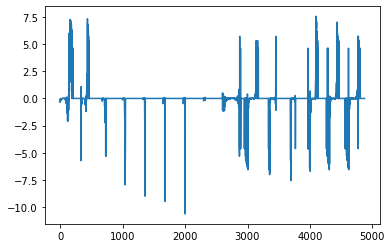

In [85]:
d = x[0] - x[1]
plt.plot(-1 * d)

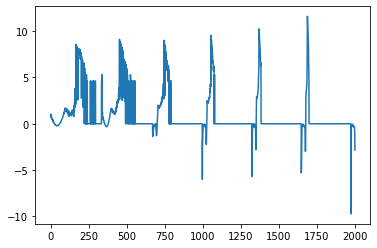

In [150]:
plt.plot(x[1][:2000])

In [144]:
# Load maxsigma data using oriented differences.
x_train, y_train = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_maxsigmas_10k_se82GnD5ep_oriented_diff_diff_training.pkl')
out9 = do_model(x_train, y_train, 30)

Epoch 1/30
507/507 [==============================] - 6s 10ms/step - loss: 34.1973 - val_loss: 20.0369
Epoch 2/30
507/507 [==============================] - 5s 9ms/step - loss: 16.8015 - val_loss: 19.2962
Epoch 3/30
507/507 [==============================] - 5s 9ms/step - loss: 14.4117 - val_loss: 18.3540
Epoch 4/30
507/507 [==============================] - 5s 10ms/step - loss: 12.3095 - val_loss: 18.3688
Epoch 5/30
507/507 [==============================] - 5s 9ms/step - loss: 10.9692 - val_loss: 18.8394
Epoch 6/30
507/507 [==============================] - 5s 10ms/step - loss: 9.4449 - val_loss: 18.9293
Epoch 7/30
507/507 [==============================] - 5s 9ms/step - loss: 9.1239 - val_loss: 18.0453
Epoch 8/30
507/507 [==============================] - 5s 9ms/step - loss: 7.8449 - val_loss: 17.3382
Epoch 9/30
507/507 [==============================] - 5s 9ms/step - loss: 6.8506 - val_loss: 18.7463
Epoch 10/30
507/507 [==============================] - 5s 9ms/step - loss: 6.2922 -

In [146]:
def do_model2(x_train, y_train, epochs=10):
    
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
        )

    def get_model(n_inputs, n_outputs):
        reg=1e-6
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(1000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(1000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(1000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        model.add(tf.keras.layers.Dense(1000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
        
        model.add(tf.keras.layers.Dense(n_outputs))
        model.compile(loss='mse', optimizer=optimizer)
        return model

    n_inputs = x_train.shape[1]
    model = get_model(n_inputs, 1)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, callbacks=[callback], verbose=True)
    return model, history

out10 = do_model2(x_train, y_train, 30)

Epoch 1/30
507/507 [==============================] - 13s 23ms/step - loss: 29.9605 - val_loss: 23.6770
Epoch 2/30
507/507 [==============================] - 11s 22ms/step - loss: 17.1575 - val_loss: 18.1208
Epoch 3/30
507/507 [==============================] - 11s 22ms/step - loss: 14.1221 - val_loss: 19.5008
Epoch 4/30
507/507 [==============================] - 11s 23ms/step - loss: 12.7284 - val_loss: 17.7061
Epoch 5/30
507/507 [==============================] - 13s 25ms/step - loss: 10.9513 - val_loss: 19.0873
Epoch 6/30
507/507 [==============================] - 12s 23ms/step - loss: 9.9370 - val_loss: 18.5735
Epoch 7/30
507/507 [==============================] - 12s 23ms/step - loss: 9.1749 - val_loss: 20.0998
Epoch 8/30
507/507 [==============================] - 11s 23ms/step - loss: 8.0703 - val_loss: 19.0882
Epoch 9/30
507/507 [==============================] - 12s 23ms/step - loss: 6.8728 - val_loss: 17.9488
Epoch 10/30
507/507 [==============================] - 12s 24ms/step

Notes on hyperparameters: going to 8x500 didn't help at all. 4x1000 seems a little better (marginal)

In [152]:
bigmodel = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_manysigmas_100k_ElF4QLXYEa_diff-model/model')

In [154]:
x_test, y_test = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_manysigmas_1k_5vnyv3lbOe_diff_training.pkl')


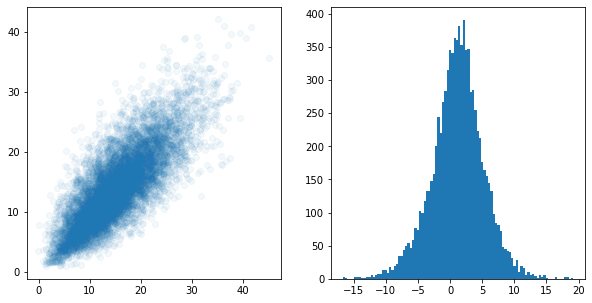

In [160]:
model = bigmodel
n=10_000
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(model.predict(x_test[:n]), y_test[:n], alpha=0.05);
plt.subplot(122)
plt.hist(model.predict(x_test[:n])- y_test[:n], bins=100);

In [161]:
history = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims_manysigmas_100k_ElF4QLXYEa_diff-model/history.pkl')

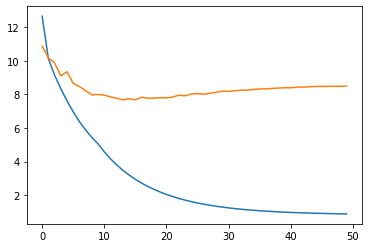

In [165]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [1]:
out10

NameError: name 'out10' is not defined